In [111]:
import math
import random
import os
import csv
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import sacrebleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Hyperparameters
EMBED_SIZE = 256
HIDDEN_SIZE = 512
ENC_LAYERS = 2
DEC_LAYERS = 2
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 10
MAX_VOCAB = 20000
MAX_LEN = 80
TEACHER_FORCING_RATIO = 0.5

# Special tokens
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"


In [112]:
from collections import Counter

def tokenize(s):
    return s.strip().lower().split()

class Vocab:
    def __init__(self, max_size=MAX_VOCAB, min_freq=1):
        self.max_size = max_size
        self.min_freq = min_freq
        self.freqs = Counter()
        self._built = False

    def add_sentence(self, sent):
        for w in tokenize(sent):
            self.freqs[w] += 1

    def build(self):
        vocab_items = [w for w, c in self.freqs.items() if c >= self.min_freq]
        vocab_items = sorted(vocab_items, key=lambda w: -self.freqs[w])
        vocab_items = vocab_items[: self.max_size - 4]
        self.idx2word = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + vocab_items
        self.word2idx = {w: i for i, w in enumerate(self.idx2word)}
        self._built = True

    def encode(self, sent, add_eos=True):
        tokens = tokenize(sent)[: MAX_LEN - 1]
        idxs = [self.word2idx.get(t, self.word2idx[UNK_TOKEN]) for t in tokens]
        if add_eos:
            idxs.append(self.word2idx[EOS_TOKEN])
        return idxs

    def decode(self, idxs, stop_at_eos=True):
        words = []
        for i in idxs:
            if i >= len(self.idx2word):
                w = UNK_TOKEN
            else:
                w = self.idx2word[i]
            if stop_at_eos and w == EOS_TOKEN:
                break
            if w not in (PAD_TOKEN, SOS_TOKEN, EOS_TOKEN):
                words.append(w)
        return " ".join(words)

    def __len__(self):
        return len(self.idx2word)



In [113]:
class ParallelDataset(Dataset):
    def __init__(self, src_sents, tgt_sents, src_vocab, tgt_vocab):
        self.src = src_sents
        self.tgt = tgt_sents
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self): return len(self.src)

    def __getitem__(self, idx):
        src_ids = self.src_vocab.encode(self.src[idx], add_eos=True)
        tgt_ids = [self.tgt_vocab.word2idx[SOS_TOKEN]] + self.tgt_vocab.encode(self.tgt[idx], add_eos=True)
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def collate_fn(batch):
    srcs, tgts = zip(*batch)
    src_lens = [len(s) for s in srcs]
    tgt_lens = [len(t) for t in tgts]
    max_src, max_tgt = max(src_lens), max(tgt_lens)
    src_pad = torch.full((len(batch), max_src), src_vocab.word2idx[PAD_TOKEN])
    tgt_pad = torch.full((len(batch), max_tgt), tgt_vocab.word2idx[PAD_TOKEN])
    for i, (s, t) in enumerate(zip(srcs, tgts)):
        src_pad[i, :len(s)] = s
        tgt_pad[i, :len(t)] = t
    return src_pad.to(DEVICE), torch.tensor(src_lens).to(DEVICE), tgt_pad.to(DEVICE), torch.tensor(tgt_lens).to(DEVICE)


In [114]:
# class Encoder(nn.Module):
#     def __init__(self, input_dim, emb_dim, hid_dim):
#         super().__init__()
#         self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=src_vocab.word2idx[PAD_TOKEN])
#         self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True)

#     def forward(self, src, src_lens):
#         embedded = self.embedding(src)
#         packed = nn.utils.rnn.pack_padded_sequence(embedded, src_lens.cpu(), batch_first=True, enforce_sorted=False)
#         outputs, (hidden, cell) = self.rnn(packed)
#         outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
#         return outputs, hidden, cell

# class BahdanauAttention(nn.Module):
#     def __init__(self, hid_dim):
#         super().__init__()
#         self.attn = nn.Linear(hid_dim * 2, hid_dim)
#         self.v = nn.Linear(hid_dim, 1, bias=False)

#     def forward(self, hidden, encoder_outputs):
#         seq_len = encoder_outputs.size(1)
#         hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
#         energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
#         attention = torch.softmax(self.v(energy).squeeze(2), dim=1)
#         context = torch.bmm(attention.unsqueeze(1), encoder_outputs).squeeze(1)
#         return context, attention

# class Decoder(nn.Module):
#     def __init__(self, output_dim, emb_dim, hid_dim, attention=None):
#         super().__init__()
#         self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=tgt_vocab.word2idx[PAD_TOKEN])
#         self.rnn = nn.LSTM(emb_dim + (hid_dim if attention else 0), hid_dim, batch_first=True)
#         self.out = nn.Linear(hid_dim * (2 if attention else 1), output_dim)
#         self.attention = attention

#     def forward(self, input, hidden, cell, encoder_outputs):
#         embedded = self.embedding(input).unsqueeze(1)
#         if self.attention:
#             context, attn = self.attention(hidden[-1], encoder_outputs)
#             rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)
#         else:
#             rnn_input, attn = embedded, None
#         output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
#         if self.attention:
#             output = torch.cat((output.squeeze(1), context), dim=1)
#         else:
#             output = output.squeeze(1)
#         pred = self.out(output)
#         return pred, hidden, cell, attn

# class Seq2Seq(nn.Module):
#     def __init__(self, encoder, decoder):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, src, src_lens, tgt=None, teacher_forcing_ratio=0.5):
#         batch_size = src.size(0)
#         tgt_len = tgt.size(1)
#         vocab_size = len(tgt_vocab)
#         outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(DEVICE)
#         encoder_outputs, hidden, cell = self.encoder(src, src_lens)
#         input_tok = torch.tensor([tgt_vocab.word2idx[SOS_TOKEN]] * batch_size).to(DEVICE)
#         for t in range(tgt_len - 1):
#             out, hidden, cell, attn = self.decoder(input_tok, hidden, cell, encoder_outputs)
#             outputs[:, t, :] = out
#             teacher_force = random.random() < teacher_forcing_ratio
#             top1 = out.argmax(1)
#             input_tok = tgt[:, t + 1] if teacher_force else top1
#         return outputs


In [115]:
# Replace these classes in your notebook with the following upgraded versions.

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, num_layers=ENC_LAYERS, padding_idx=None):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=padding_idx)
        self.hid_dim = hid_dim
        self.num_layers = num_layers

        # stacked LSTM
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers, batch_first=True)

        # projection for residual connection: project embedding dim -> hidden dim
        # so we can add (projected) embedding to LSTM outputs (shape match)
        if emb_dim != hid_dim:
            self.res_proj = nn.Linear(emb_dim, hid_dim)
        else:
            self.res_proj = None

    def forward(self, src, src_lens):
        """
        src: (batch, src_len) long tensor
        src_lens: (batch,) tensor of lengths (used for packing)
        returns: encoder_outputs (padded, B, T, H), hidden, cell
        hidden, cell shapes: (num_layers, batch, hid_dim)
        """
        embedded = self.embedding(src)  # (B, T, E)

        # pack padded sequence for efficiency
        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_lens.cpu(), batch_first=True, enforce_sorted=False)
        packed_outputs, (hidden, cell) = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)  # (B, T, H)

        # apply residual: add projected embedding to outputs
        if self.res_proj is not None:
            proj = self.res_proj(embedded)   # (B, T, H)
        else:
            proj = embedded                  # shapes match if E==H

        # It's usually sensible to only add residual from input to top-layer outputs.
        # outputs already contains the top-layer output per time-step.
        outputs = outputs + proj

        return outputs, hidden, cell


class BahdanauAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        # keep the same shape behavior as your original implementation
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        """
        hidden: (batch, hid_dim)  -- note: we will pass decoder hidden[-1]
        encoder_outputs: (batch, src_len, hid_dim)
        returns: context (batch, hid_dim), attention (batch, src_len)
        """
        seq_len = encoder_outputs.size(1)
        # expand hidden to (batch, seq_len, hid_dim)
        hidden_exp = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden_exp, encoder_outputs), dim=2)))  # (B, T, H)
        scores = self.v(energy).squeeze(2)  # (B, T)
        attention = torch.softmax(scores, dim=1)  # (B, T)
        context = torch.bmm(attention.unsqueeze(1), encoder_outputs).squeeze(1)  # (B, H)
        return context, attention


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, attention=None, num_layers=DEC_LAYERS, padding_idx=None):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=padding_idx)
        self.attention = attention
        self.hid_dim = hid_dim
        self.num_layers = num_layers

        # input size depends on whether we use attention (we concatenate context)
        input_size = emb_dim + hid_dim if attention is not None else emb_dim

        # stacked LSTM (decoder)
        self.rnn = nn.LSTM(input_size, hid_dim, num_layers=num_layers, batch_first=True)

        # projection for decoder residual (project input_size -> hid_dim)
        if input_size != hid_dim:
            self.res_proj = nn.Linear(input_size, hid_dim)
        else:
            self.res_proj = None

        # output layer:
        # if attention: we concatenate decoder output (hid_dim) and context (hid_dim) => 2*hid_dim
        self.out = nn.Linear(hid_dim * (2 if attention else 1), output_dim)

    def forward(self, input_token, hidden, cell, encoder_outputs):
        """
        input_token: (batch,) long tensor of previous token ids
        hidden, cell: (num_layers, batch, hid_dim)
        encoder_outputs: (batch, src_len, hid_dim)
        Returns:
            pred (batch, output_dim) logits
            hidden, cell (updated)
            attn (batch, src_len) or None
        """
        # embed and make time-dim
        embedded = self.embedding(input_token).unsqueeze(1)  # (B, 1, E)

        # attention: compute context using top-layer decoder hidden state (hidden[-1])
        if self.attention is not None:
            context, attn = self.attention(hidden[-1], encoder_outputs)     # context: (B, H)
            context = context.unsqueeze(1)                                  # (B, 1, H)
            rnn_input = torch.cat((embedded, context), dim=2)               # (B, 1, E+H)
        else:
            attn = None
            rnn_input = embedded                                            # (B, 1, E)

        # compute projection for residual
        if self.res_proj is not None:
            proj = self.res_proj(rnn_input)     # (B, 1, H)
        else:
            proj = rnn_input                    # (B, 1, H) if sizes match

        # run through stacked LSTM
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))  # output: (B, 1, H)

        # add residual (align shapes)
        output = output + proj  # (B, 1, H)

        # prepare final vector for out: optionally concat with context (same as before)
        if self.attention is not None:
            # squeeze time dim
            output_squeezed = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)  # (B, 2H)
        else:
            output_squeezed = output.squeeze(1)  # (B, H)

        pred = self.out(output_squeezed)  # (B, output_dim)

        return pred, hidden, cell, attn


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, tgt_vocab_obj):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_vocab = tgt_vocab_obj

    def forward(self, src, src_lens, tgt=None, teacher_forcing_ratio=TEACHER_FORCING_RATIO):
        """
        src: (B, src_len)
        src_lens: (B,)
        tgt: (B, tgt_len) including <sos> at position 0
        returns: outputs (B, tgt_len, vocab_size) logits for each step
        """
        batch_size = src.size(0)
        assert tgt is not None, "This forward expects target tensor for training mode"

        tgt_len = tgt.size(1)
        vocab_size = len(self.tgt_vocab)
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(DEVICE)

        # encoder
        encoder_outputs, hidden, cell = self.encoder(src, src_lens)
        # hidden, cell shapes: (enc_num_layers, B, H)
        # decoder expects hidden/cell with shape (dec_num_layers, B, H)
        # if enc/dec layers differ, you might want to project or repeat; simplest assumption:
        # here we assume enc_num_layers == dec_num_layers; if not, you should adapt/init properly.
        # (If they differ you can initialize decoder hidden with encoder final states for last layer(s).)

        # first input to the decoder is <sos>
        input_tok = torch.tensor([self.tgt_vocab.word2idx[SOS_TOKEN]] * batch_size).to(DEVICE)

        for t in range(tgt_len - 1):  # we predict up to tgt_len-1 (since last target is EOS)
            out, hidden, cell, attn = self.decoder(input_tok, hidden, cell, encoder_outputs)
            outputs[:, t, :] = out

            # next input: teacher forcing or previous prediction
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = out.argmax(1)
            input_tok = tgt[:, t + 1] if teacher_force else top1

        return outputs


In [116]:
def load_csv_split(path, target_lang):
    """
    Load a CSV file containing parallel data with 'indonesian' as source column
    and the target language column (e.g. 'madurese', 'javanese').
    """
    df = pd.read_csv(path, index_col=0, dtype=str)  # skip the first unnamed index column
    src_col = "indonesian"
    tgt_col = target_lang.lower()
    if src_col not in df.columns or tgt_col not in df.columns:
        raise ValueError(f"Expected columns '{src_col}' and '{tgt_col}' in {path}")
    src_texts = df[src_col].astype(str).tolist()
    tgt_texts = df[tgt_col].astype(str).tolist()
    return src_texts, tgt_texts



In [117]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for src, src_lens, tgt, _ in tqdm(dataloader):
        optimizer.zero_grad()
        out = model(src, src_lens, tgt)
        loss = criterion(out[:, :-1].reshape(-1, out.size(-1)), tgt[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


In [118]:
def visualize_attention(model, sentence):
    model.eval()
    src_ids = src_vocab.encode(sentence, add_eos=True)
    src_tensor = torch.tensor([src_ids]).to(DEVICE)
    src_len = torch.tensor([len(src_ids)]).to(DEVICE)
    with torch.no_grad():
        enc_out, hidden, cell = model.encoder(src_tensor, src_len)
        input_tok = torch.tensor([tgt_vocab.word2idx[SOS_TOKEN]]).to(DEVICE)
        decoded, attn_mats = [], []
        for _ in range(30):
            pred, hidden, cell, attn = model.decoder(input_tok, hidden, cell, enc_out)
            top1 = pred.argmax(1)
            decoded.append(top1.item())
            if attn is not None: attn_mats.append(attn.squeeze(0).cpu().numpy())
            input_tok = top1
            if top1.item() == tgt_vocab.word2idx[EOS_TOKEN]: break
    if not attn_mats:
        print("No attention weights available.")
        return
    attn = np.stack(attn_mats)
    src_tokens = tokenize(sentence) + [EOS_TOKEN]
    pred_tokens = [tgt_vocab.idx2word[i] for i in decoded]
    plt.figure(figsize=(len(src_tokens)*0.6, len(pred_tokens)*0.6))
    sns.heatmap(attn, xticklabels=src_tokens, yticklabels=pred_tokens, cmap='viridis')
    plt.xlabel("Source (Indonesian)")
    plt.ylabel("Target Prediction")
    plt.title("Attention Heatmap")
    plt.show()


In [121]:
import os
import torch
from tqdm import tqdm

def run_experiment(base_dir, target_lang="jv", attention_type=False, num_epochs=None, device=None):
    """
    Train a Seq2Seq model (with or without attention) and record loss per epoch.
    Returns: model, epoch_losses
    """
    print(f"Training Indonesian → {target_lang.upper()} ({'with attention' if attention_type else 'no attention'})")

    # Data loading
    train_src, train_tgt = load_csv_split(os.path.join(base_dir, "train.csv"), target_lang)
    valid_src, valid_tgt = load_csv_split(os.path.join(base_dir, "valid.csv"), target_lang)

    # Vocabulary setup
    global src_vocab, tgt_vocab
    src_vocab, tgt_vocab = Vocab(), Vocab()
    for s in train_src: src_vocab.add_sentence(s)
    for t in train_tgt: tgt_vocab.add_sentence(t)
    src_vocab.build(); tgt_vocab.build()

    # Dataset and Loader
    train_ds = ParallelDataset(train_src, train_tgt, src_vocab, tgt_vocab)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

    # Device and model creation 
    if device is None:
        device = DEVICE
    enc = Encoder(len(src_vocab), EMBED_SIZE, HIDDEN_SIZE, num_layers=ENC_LAYERS, padding_idx=src_vocab.word2idx[PAD_TOKEN]).to(device)
    attn = BahdanauAttention(HIDDEN_SIZE).to(device) if attention_type else None
    dec = Decoder(len(tgt_vocab), EMBED_SIZE, HIDDEN_SIZE, attention=attn, num_layers=DEC_LAYERS, padding_idx=tgt_vocab.word2idx[PAD_TOKEN]).to(device)

    model = Seq2Seq(enc, dec, tgt_vocab).to(device)
    # Optimizer and Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.word2idx[PAD_TOKEN])

    if num_epochs is None:
        num_epochs = EPOCHS 

    # Training loop
    epoch_losses = []
    for epoch in range(1, num_epochs + 1):
        loss = train_epoch(model, train_loader, optimizer, criterion)
        epoch_losses.append(loss)
        print(f"Epoch {epoch}/{num_epochs} Loss: {loss:.4f}")

    # Save the model
    save_path = f"model_id2{target_lang}_{'attn' if attention_type else 'noattn'}.pt"
    torch.save(model.state_dict(), save_path)
    print("Model saved to", save_path)

    return model, epoch_losses



Training Indonesian → JAVANESE (no attention)


100%|██████████| 8/8 [00:30<00:00,  3.84s/it]


Epoch 1/10 Loss: 8.0031


100%|██████████| 8/8 [00:29<00:00,  3.67s/it]


Epoch 2/10 Loss: 7.0306


100%|██████████| 8/8 [00:32<00:00,  4.11s/it]


Epoch 3/10 Loss: 6.7677


100%|██████████| 8/8 [00:30<00:00,  3.87s/it]


Epoch 4/10 Loss: 6.6071


100%|██████████| 8/8 [00:29<00:00,  3.66s/it]


Epoch 5/10 Loss: 6.4606


100%|██████████| 8/8 [00:29<00:00,  3.71s/it]


Epoch 6/10 Loss: 6.3017


100%|██████████| 8/8 [00:29<00:00,  3.63s/it]


Epoch 7/10 Loss: 6.2103


100%|██████████| 8/8 [00:30<00:00,  3.86s/it]


Epoch 8/10 Loss: 6.1470


100%|██████████| 8/8 [00:29<00:00,  3.69s/it]


Epoch 9/10 Loss: 5.8968


100%|██████████| 8/8 [00:28<00:00,  3.60s/it]


Epoch 10/10 Loss: 5.8407
Model saved to model_id2javanese_noattn.pt
Training Indonesian → JAVANESE (with attention)


100%|██████████| 8/8 [01:07<00:00,  8.38s/it]


Epoch 1/10 Loss: 7.8419


100%|██████████| 8/8 [01:10<00:00,  8.78s/it]


Epoch 2/10 Loss: 6.9777


100%|██████████| 8/8 [01:05<00:00,  8.14s/it]


Epoch 3/10 Loss: 6.6725


100%|██████████| 8/8 [01:07<00:00,  8.47s/it]


Epoch 4/10 Loss: 6.3501


100%|██████████| 8/8 [01:05<00:00,  8.24s/it]


Epoch 5/10 Loss: 6.0922


100%|██████████| 8/8 [01:08<00:00,  8.59s/it]


Epoch 6/10 Loss: 5.8086


100%|██████████| 8/8 [01:07<00:00,  8.40s/it]


Epoch 7/10 Loss: 5.5382


100%|██████████| 8/8 [01:08<00:00,  8.51s/it]


Epoch 8/10 Loss: 5.1956


100%|██████████| 8/8 [01:09<00:00,  8.70s/it]


Epoch 9/10 Loss: 4.8434


100%|██████████| 8/8 [01:04<00:00,  8.06s/it]


Epoch 10/10 Loss: 4.4897
Model saved to model_id2javanese_attn.pt
Training Indonesian → MADURESE (no attention)


100%|██████████| 8/8 [00:30<00:00,  3.86s/it]


Epoch 1/10 Loss: 7.9775


100%|██████████| 8/8 [00:29<00:00,  3.75s/it]


Epoch 2/10 Loss: 6.9595


100%|██████████| 8/8 [00:29<00:00,  3.74s/it]


Epoch 3/10 Loss: 6.6863


100%|██████████| 8/8 [00:28<00:00,  3.57s/it]


Epoch 4/10 Loss: 6.5860


100%|██████████| 8/8 [00:30<00:00,  3.78s/it]


Epoch 5/10 Loss: 6.3724


100%|██████████| 8/8 [00:29<00:00,  3.73s/it]


Epoch 6/10 Loss: 6.2552


100%|██████████| 8/8 [00:29<00:00,  3.68s/it]


Epoch 7/10 Loss: 6.0704


100%|██████████| 8/8 [00:29<00:00,  3.74s/it]


Epoch 8/10 Loss: 5.9759


100%|██████████| 8/8 [00:29<00:00,  3.71s/it]


Epoch 9/10 Loss: 5.8860


100%|██████████| 8/8 [00:31<00:00,  3.98s/it]


Epoch 10/10 Loss: 5.8446
Model saved to model_id2madurese_noattn.pt
Training Indonesian → MADURESE (with attention)


100%|██████████| 8/8 [01:13<00:00,  9.21s/it]


Epoch 1/10 Loss: 8.0061


100%|██████████| 8/8 [01:14<00:00,  9.31s/it]


Epoch 2/10 Loss: 7.0158


100%|██████████| 8/8 [01:20<00:00, 10.04s/it]


Epoch 3/10 Loss: 6.6747


100%|██████████| 8/8 [01:23<00:00, 10.40s/it]


Epoch 4/10 Loss: 6.4344


100%|██████████| 8/8 [01:16<00:00,  9.55s/it]


Epoch 5/10 Loss: 6.2403


100%|██████████| 8/8 [01:16<00:00,  9.59s/it]


Epoch 6/10 Loss: 6.0308


100%|██████████| 8/8 [01:11<00:00,  8.89s/it]


Epoch 7/10 Loss: 5.7246


100%|██████████| 8/8 [01:13<00:00,  9.23s/it]


Epoch 8/10 Loss: 5.4191


100%|██████████| 8/8 [01:16<00:00,  9.52s/it]


Epoch 9/10 Loss: 5.0741


100%|██████████| 8/8 [01:15<00:00,  9.39s/it]


Epoch 10/10 Loss: 4.6840
Model saved to model_id2madurese_attn.pt


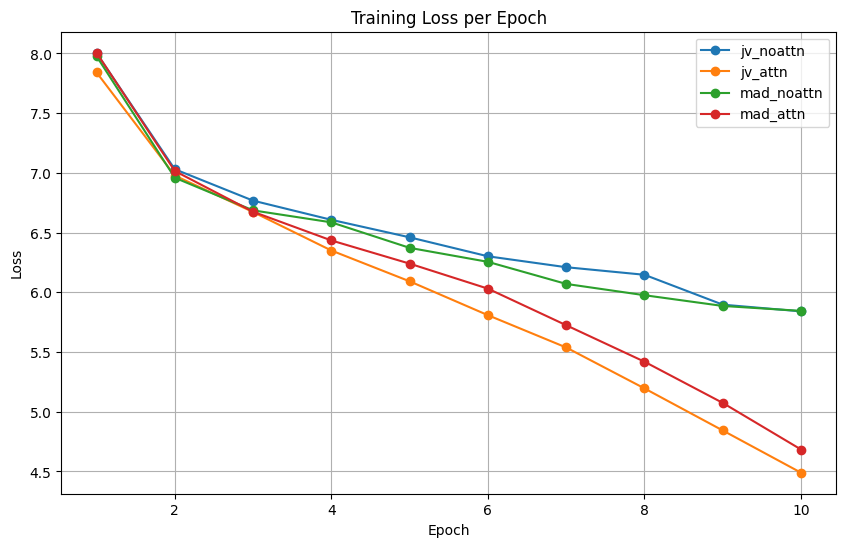

In [122]:
base_dir = "./nusax-main/datasets/mt"

model_jv_noattn, losses_jv_noattn = run_experiment(base_dir,target_lang="javanese", attention_type=False)
model_jv_attn,  losses_jv_attn  = run_experiment(base_dir, target_lang="javanese", attention_type=True)
model_mad_noattn, losses_mad_noattn = run_experiment(base_dir, target_lang="madurese", attention_type=False)
model_mad_attn, losses_mad_attn = run_experiment(base_dir, target_lang="madurese", attention_type=True)

loss_dict = {
    "jv_noattn": losses_jv_noattn,
    "jv_attn": losses_jv_attn,
    "mad_noattn": losses_mad_noattn,
    "mad_attn": losses_mad_attn
}

plt.figure(figsize=(10,6))
for name, losses in loss_dict.items():
    if losses is None:
        continue
    epochs = list(range(1, len(losses)+1))
    plt.plot(epochs, losses, marker='o', label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


In [123]:
def plot_attention(attn_matrix, src_tokens, tgt_tokens, title):
    """
    attn_matrix: (tgt_len, src_len)
    src_tokens:  list of strings
    tgt_tokens:  list of strings
    """
    import matplotlib.pyplot as plt
    import numpy as np

    attn = attn_matrix[:len(tgt_tokens), :len(src_tokens)]  # trim paddings

    plt.figure(figsize=(10, 8))
    plt.imshow(attn, interpolation='nearest', aspect='auto')
    plt.colorbar()

    plt.xticks(ticks=np.arange(len(src_tokens)), labels=src_tokens, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(tgt_tokens)), labels=tgt_tokens)

    plt.xlabel("Source tokens")
    plt.ylabel("Decoder steps (predicted tokens)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [124]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, device=DEVICE, max_len=80):
    model.eval()

    src_tokens = sentence.lower().split()
    src_indices = [src_vocab.word2idx.get(tok, src_vocab.word2idx[UNK_TOKEN]) for tok in src_tokens]
    src_tensor = torch.tensor([src_indices]).to(device)
    src_lens = torch.tensor([len(src_indices)]).to(device)

    with torch.no_grad():
        enc_outputs, hidden, cell = model.encoder(src_tensor, src_lens)

    input_tok = torch.tensor([tgt_vocab.word2idx[SOS_TOKEN]]).to(device)

    preds = []
    attn_weights = []

    for _ in range(max_len):
        output, hidden, cell, attn = model.decoder(input_tok, hidden, cell, enc_outputs)

        if attn is not None:
            attn_weights.append(attn.squeeze(0).detach().cpu().numpy())

        pred_id = output.argmax(1).item()
        preds.append(pred_id)

        if pred_id == tgt_vocab.word2idx[EOS_TOKEN]:
            break

        input_tok = torch.tensor([pred_id]).to(device)

    tgt_tokens = [tgt_vocab.idx2word[i] for i in preds]
    pred_sentence = " ".join(token for token in tgt_tokens if token not in [EOS_TOKEN, PAD_TOKEN])

    attn_matrix = np.stack(attn_weights) if attn_weights else None

    return pred_sentence, attn_matrix, src_tokens, tgt_tokens



=== Evaluating jv_noattn (javanese) ===


100%|██████████| 400/400 [00:17<00:00, 22.45it/s]


BLEU = 0.005
Avg ROUGE-1 F1 = 0.0010, ROUGE-L F1 = 0.0010

Example (idx = 254):
SOURCE   : Mencoba memesan shabu-shabu, menu baru di gading resto. Kualitas rasa cukup enak, harga terjangkau pula. Rekomendasi bilamana membawa tamu atau sekadar makan malam bersama keluarga.
GROUND   : Njajal pesen shabu-shabu, menu anyar ning gading resto. Kuwalitas rasane cukup enak, regane kejangkau uga. Rekomendasi lak nggawa tamu utawa mung mangan wengi karo kaluwarga.
PREDICTED: ben ghebey tak ghebey ka e se se se se se se se se se se se se se se se
No attention available.

=== Evaluating jv_attn (javanese) ===


100%|██████████| 400/400 [00:41<00:00,  9.75it/s]


BLEU = 0.010
Avg ROUGE-1 F1 = 0.0009, ROUGE-L F1 = 0.0009

Example (idx = 254):
SOURCE   : Mencoba memesan shabu-shabu, menu baru di gading resto. Kualitas rasa cukup enak, harga terjangkau pula. Rekomendasi bilamana membawa tamu atau sekadar makan malam bersama keluarga.
GROUND   : Njajal pesen shabu-shabu, menu anyar ning gading resto. Kuwalitas rasane cukup enak, regane kejangkau uga. Rekomendasi lak nggawa tamu utawa mung mangan wengi karo kaluwarga.
PREDICTED: tak tak tak tak tak tak tak tak


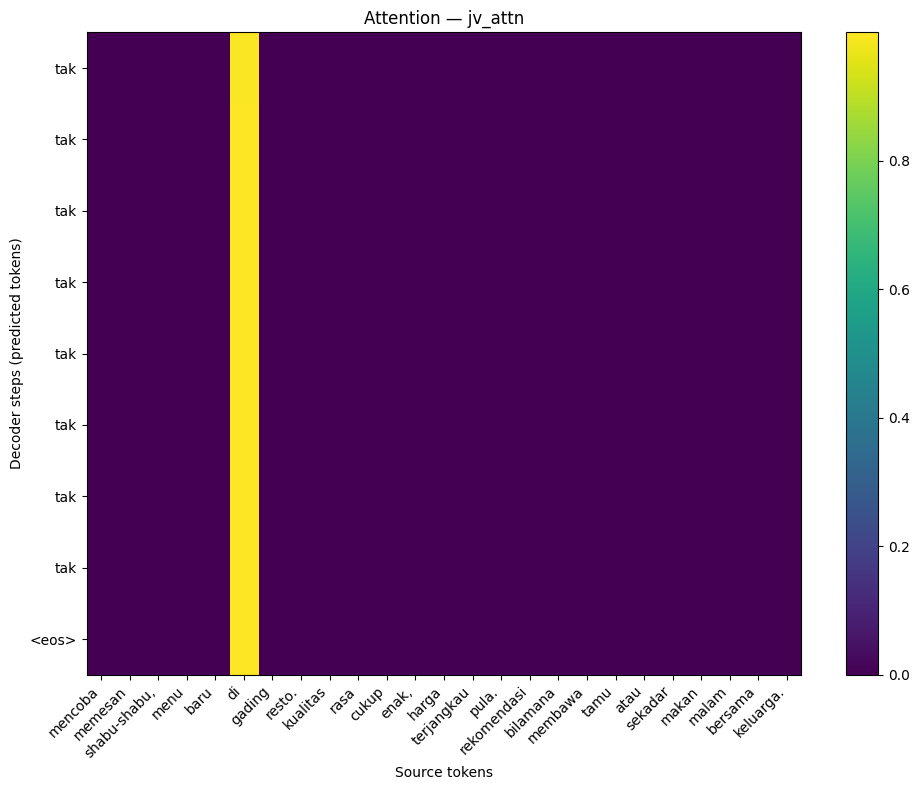


=== Evaluating mad_noattn (madurese) ===


100%|██████████| 400/400 [00:15<00:00, 25.56it/s]


BLEU = 0.065
Avg ROUGE-1 F1 = 0.0890, ROUGE-L F1 = 0.0796

Example (idx = 254):
SOURCE   : Mencoba memesan shabu-shabu, menu baru di gading resto. Kualitas rasa cukup enak, harga terjangkau pula. Rekomendasi bilamana membawa tamu atau sekadar makan malam bersama keluarga.
GROUND   : Cobak mesen sabhu-sabhu, menu anyar e gading resto. kualitas rassana cokop nyaman. Regghena terjangkau kia. rekomendasi mun nyambi tamui otabe sakeddher ngakan malem bik kaluarga.
PREDICTED: engkok bik se e se se se se se se se se se se se se se se e
No attention available.

=== Evaluating mad_attn (madurese) ===


100%|██████████| 400/400 [00:27<00:00, 14.79it/s]


BLEU = 0.058
Avg ROUGE-1 F1 = 0.1152, ROUGE-L F1 = 0.1061

Example (idx = 254):
SOURCE   : Mencoba memesan shabu-shabu, menu baru di gading resto. Kualitas rasa cukup enak, harga terjangkau pula. Rekomendasi bilamana membawa tamu atau sekadar makan malam bersama keluarga.
GROUND   : Cobak mesen sabhu-sabhu, menu anyar e gading resto. kualitas rassana cokop nyaman. Regghena terjangkau kia. rekomendasi mun nyambi tamui otabe sakeddher ngakan malem bik kaluarga.
PREDICTED: mun e e e e e e e e


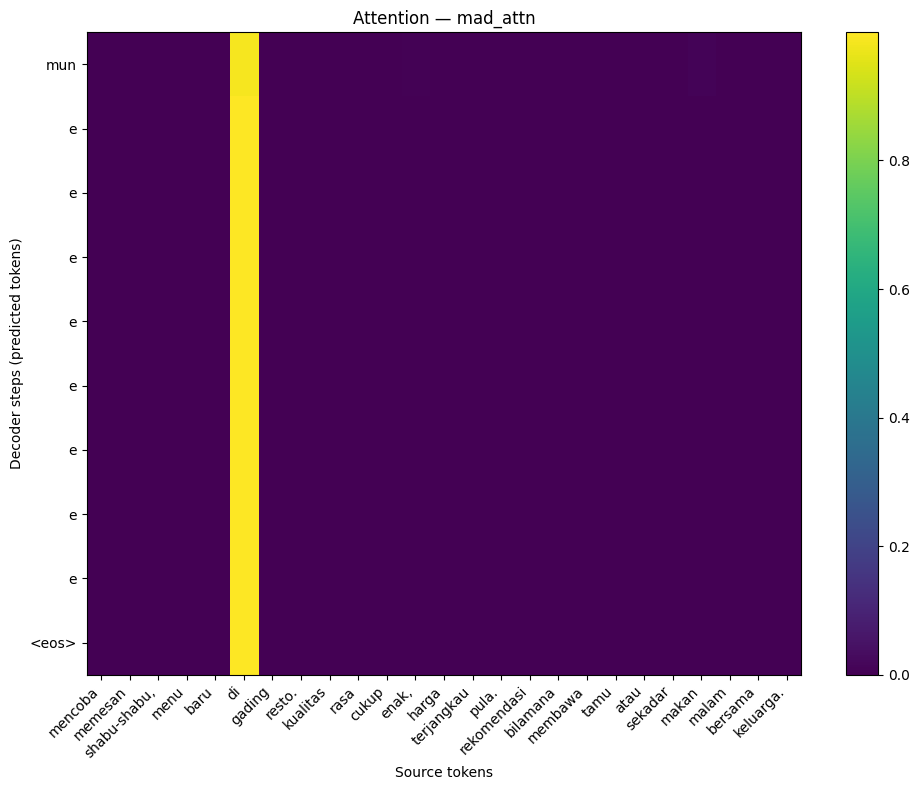

In [126]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer
from tqdm import tqdm

def load_test_csv(path, target_lang):
    df = pd.read_csv(path, index_col=0, dtype=str)  # skip unnamed index col
    src_col = "indonesian"
    tgt_col = target_lang.lower()
    if src_col not in df.columns or tgt_col not in df.columns:
        raise ValueError(f"Expected columns '{src_col}' and '{tgt_col}' in {path}")
    src_texts = df[src_col].astype(str).tolist()
    tgt_texts = df[tgt_col].astype(str).tolist()
    return src_texts, tgt_texts

# Evaluation setup
base_dir = globals().get("base_dir", ".")
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
random.seed(42)
sample_index = random.randrange(1000)  # one fixed index for all models
all_results = {}

# Evaluate each model
for model_name, model in models_to_eval:
    # Detect which target language to evaluate
    if "jv" in model_name:
        target_lang = "javanese"
    elif "mad" in model_name:
        target_lang = "madurese"
    else:
        continue  # skip if not one of the two
    
    print(f"\n=== Evaluating {model_name} ({target_lang}) ===")

    test_srcs, test_tgts = load_test_csv(os.path.join(base_dir, "test.csv"), target_lang)

    preds, refs = [], []
    for src, tgt in tqdm(zip(test_srcs, test_tgts), total=len(test_srcs)):
        pred, attn_matrix, _, _ = translate_sentence(
            model, src, src_vocab, tgt_vocab, device=DEVICE
        )
        preds.append(pred)
        refs.append(tgt)

    # Compute BLEU (expects list of references as list-of-list)
    bleu = corpus_bleu(preds, [refs])

    # Compute averaged ROUGE
    rouge1_f, rougeL_f = [], []
    for p, r in zip(preds, refs):
        score = scorer.score(r, p)
        rouge1_f.append(score['rouge1'].fmeasure)
        rougeL_f.append(score['rougeL'].fmeasure)
    avg_rouge1_f = float(np.mean(rouge1_f))
    avg_rougeL_f = float(np.mean(rougeL_f))

    all_results[model_name] = {
        "bleu_score": float(bleu.score),
        "rouge1_f": avg_rouge1_f,
        "rougeL_f": avg_rougeL_f
    }

    print(f"BLEU = {bleu.score:.3f}")
    print(f"Avg ROUGE-1 F1 = {avg_rouge1_f:.4f}, ROUGE-L F1 = {avg_rougeL_f:.4f}")

    # Show one example and heatmap  
    idx = sample_index % len(test_srcs)
    print("\nExample (idx = {}):".format(idx))
    print("SOURCE   :", test_srcs[idx])
    print("GROUND   :", test_tgts[idx])

    pred_ex, attn_matrix, src_tokens, tgt_tokens = translate_sentence(
        model, test_srcs[idx], src_vocab, tgt_vocab, device=DEVICE
    )

    print("PREDICTED:", pred_ex)   # <-- added line

    if attn_matrix is not None:
        plot_attention(attn_matrix, src_tokens, tgt_tokens, f"Attention — {model_name}")
    else:
        print("No attention available.")
